<a href="https://colab.research.google.com/github/Katsushi-Nakanishi/QuantMacro_sp2/blob/main/QuantMacro_kadai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing libralies

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [3]:
# define a utility function
def util(cons, gamma):
    return max(cons, 1e-4) ** (1.0-gamma) / (1.0-gamma)

# cos > 0 が必ず成り立たなければならない⇒1e-4とのmaxをとる

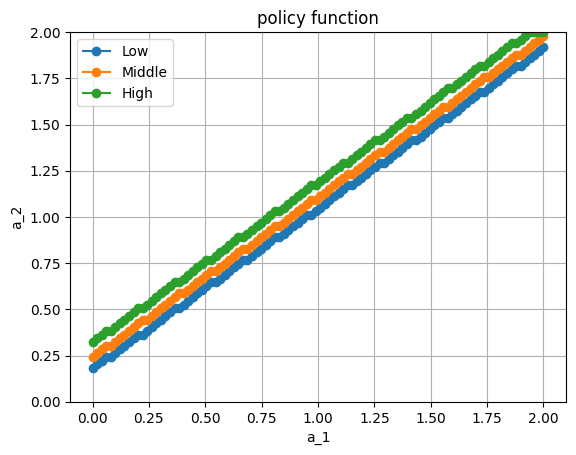

In [4]:
# 年金がない場合

# parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.0])   # 3期目の所得は０
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281,0.1361],
    [0.0021, 0.2528, 0.7451]
])
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL]) # 初期分布の仮定

mu_2 = np.zeros(NL)  # 2期目の分布を入れる箱を作っておく

# 2期目の分布を計算
for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp] *mu_1[il]

# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))


# backward induction
# period 3
for ia in range(NA):
        v[2, ia, :] = util(y[2] + (1.0 + r) * a[ia], gamma) # util(c, gamma)
        # 3期目の所得y[2]は０

# period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA) # 各番号アセットについてバリューをいったん格納
        for iap in range(NA):
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*v[2, iap, 0] # 1でも2でもいい
        iaplus[1, ia, il] = np.argmax(reward)
        aplus[1, ia, il] = a[iaplus[1, ia, il]]
        v[1, ia, il] = reward[iaplus[1, ia, il]]

# period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp]*v[1,iap, ilp] # ここではiap固定でilpが確率によって変動するときの期待値
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

        iaplus[0, ia, il] = np.argmax(reward)
        aplus[0, ia, il] = a[iaplus[0, ia, il]]
        v[0, ia, il] = reward[iaplus[0, ia, il]]


plt.figure()
plt.plot(a, aplus[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus[0, :, 1], marker='o', label='Middle')
plt.plot(a, aplus[0, :, 2], marker='o', label='High')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()


In [5]:
print(mu_2)

[0.2944     0.41123333 0.29443333]


In [6]:
print(0.2944*0.8027 + 0.41123333*1.0 + 0.29443333*1.2457)

1.014323809181


In [7]:
nen = 1.014323809181 * 0.3
print(nen)

0.30429714275430003


In [8]:
nen * (1 + r)

0.49862630085058907

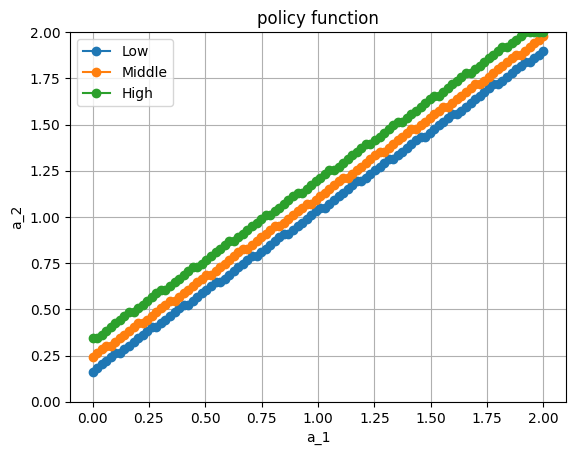

In [9]:
# 3期モデル（年金ありの場合）

# parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.0])  # 3期目の所得は０
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281,0.1361],
    [0.0021, 0.2528, 0.7451]
])
# 若年期の所得分布
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL])

# 中年期の所得分布
mu_2 = np.zeros(NL)  # NL個入る箱を作っておく

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp] *mu_1[il]

# 全人口の中年期の総所得と年金を計算
tincome = np.dot(mu_2, l)
pension = (1.0 + r) * (tincome * 0.3)

# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))


# backward induction
# period 3
for ia in range(NA):
        v[2, ia, :] = util(pension + (1.0 + r) * a[ia], gamma) # util(c, gamma)
        # 3期目はilに依存しないのでこう書いている。

# period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA) # 各番号アセットについてバリューをいったん格納
        for iap in range(NA):
            reward[iap] = util(l[il]  * (1.0 - 0.3) + (1.0+r)*a[ia] - a[iap], gamma) + beta*v[2, iap, 0] # 1でも2でもいい
        iaplus[1, ia, il] = np.argmax(reward)
        aplus[1, ia, il] = a[iaplus[1, ia, il]]
        v[1, ia, il] = reward[iaplus[1, ia, il]]

# period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            EV = 0.0
            for ilp in range(NL):\
                EV += prob[il, ilp]*v[1,iap, ilp] # ここではiap固定でilpが確率によって変動するときの期待値
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

        iaplus[0, ia, il] = np.argmax(reward)
        aplus[0, ia, il] = a[iaplus[0, ia, il]]
        v[0, ia, il] = reward[iaplus[0, ia, il]]


plt.figure()
plt.plot(a, aplus[0, :, 0], marker='o', label='Low') # 1期目の生産性Lのときのアセットによる変動
plt.plot(a, aplus[0, :, 1], marker='o', label='Middle')
plt.plot(a, aplus[0, :, 2], marker='o', label='High')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()


In [10]:
# 年金がない場合

# parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.0])   # 3期目の所得は０
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281,0.1361],
    [0.0021, 0.2528, 0.7451]
])
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL]) # 初期分布の仮定

mu_2 = np.zeros(NL)  # 2期目の分布を入れる箱を作っておく

# 2期目の分布を計算
for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp] *mu_1[il]

# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))


# backward induction
# period 3
for ia in range(NA):
        v[2, ia, :] = util(y[2] + (1.0 + r) * a[ia], gamma) # util(c, gamma)
        # 3期目の所得y[2]は０

# period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA) # 各番号アセットについてバリューをいったん格納
        for iap in range(NA):
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*v[2, iap, 0] # 1でも2でもいい
        iaplus[1, ia, il] = np.argmax(reward)
        aplus[1, ia, il] = a[iaplus[1, ia, il]]
        v[1, ia, il] = reward[iaplus[1, ia, il]]

# period 1 (期初の資産をすべて０とする)
for il in range(NL):
    ia = 0
    reward = np.zeros(NA)
    for iap in range(NA):
        EV = 0.0
        for ilp in range(NL):
            EV += prob[il, ilp]*v[1,iap, ilp] # ここではiap固定でilpが確率によって変動するときの期待値
        reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

    iaplus[0, ia, il] = np.argmax(reward)
    aplus[0, ia, il] = a[iaplus[0, ia, il]]
    v[0, ia, il] = reward[iaplus[0, ia, il]]


TEV = np.dot(mu_1, v[0, 0, :])
print(TEV)

-2.837002656808882


In [11]:
# 3期モデル（年金ありの場合）

# parameters
gamma = 2.0
beta = 0.985 ** 20
r = 1.025 ** 20 - 1.0
y = np.array([1.0, 1.2, 0.0])  # 3期目の所得は０
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281,0.1361],
    [0.0021, 0.2528, 0.7451]
])
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL]) # 初期分布の仮定

mu_2 = np.zeros(NL)  # NL個入る箱を作っておく

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp] *mu_1[il]

# 全人口の中年期の総収入と年金を計算
tincome = np.dot(mu_2, l)
pension = (1.0 + r) * (tincome * 0.3)

# grids
a_l = 0.0
a_u = 2.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v = np.zeros((JJ, NA, NL))
iaplus = np.zeros((JJ, NA, NL), dtype=int)
aplus = np.zeros((JJ, NA, NL))


# backward induction
# period 3
for ia in range(NA):
        v[2, ia, :] = util(pension + (1.0 + r) * a[ia], gamma) # util(c, gamma)
        # 3期目はilに依存しないのでこう書いている。

# period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA) # 各番号アセットについてバリューをいったん格納
        for iap in range(NA):
            reward[iap] = util(l[il]  * (1.0 - 0.3) + (1.0+r)*a[ia] - a[iap], gamma) + beta*v[2, iap, 0] # 1でも2でもいい
        iaplus[1, ia, il] = np.argmax(reward)
        aplus[1, ia, il] = a[iaplus[1, ia, il]]
        v[1, ia, il] = reward[iaplus[1, ia, il]]

# period 1
for il in range(NL):
    ia = 0
    reward = np.zeros(NA)
    for iap in range(NA):
        EV = 0.0
        for ilp in range(NL):\
            EV += prob[il, ilp]*v[1,iap, ilp] # ここではiap固定でilpが確率によって変動するときの期待値
        reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta*EV

    iaplus[0, ia, il] = np.argmax(reward)
    aplus[0, ia, il] = a[iaplus[0, ia, il]]
    v[0, ia, il] = reward[iaplus[0, ia, il]]

TEV = np.dot(mu_1, v[0, 0, :])
print(TEV)

-2.8196108915740563
